In [1]:
%matplotlib inline

### Imports

In [2]:
import pandas as pd
import sqlite3 as lite
import sys,os,glob,re
import zipfile
import matplotlib.pyplot as plt

In [3]:
cwd = os.getcwd()

In [4]:
zf = zipfile.ZipFile(cwd + '\\dutch-energy.zip')
#csv_files = zf.infolist()
csv_files = zf.namelist()
liste_csv = [f for f in csv_files if f.endswith('.csv')]
liste_fname = []
pattern ='\/(\S+)\.'
for i in range(len(liste_csv)):
    fin=re.findall(pattern, liste_csv[i])
    if fin != []:
        liste_fname.append(fin[0])
        

In [5]:
zf

<zipfile.ZipFile filename='C:\\Users\\tobia\\Documents\\python\\DutchEnergy\\dutch-energy.zip' mode='r'>

In [6]:
db_name = 'Dutch-Energy_DB.db' 

fillDB=False

if fillDB:
    print ("Uncompressing and reading data... ")

    for i in range(len(liste_csv)):
    #for i in range(1):
        print(liste_csv[i])
        df = pd.read_csv(zf.open(liste_csv[i]))
        # do df manipulations
        conn = lite.connect(db_name)
        cur = conn.cursor()
        cur.execute('DROP TABLE IF EXISTS '+liste_fname[i])
        print("Writing to db-file "+db_name+": "+liste_fname[i])
        df.to_sql(liste_fname[i], conn, if_exists='replace', index=False) # - writes the pd.df to SQLIte DB
        pd.read_sql('select * from '+liste_fname[i], conn)
        conn.commit()
        conn.close()

In [7]:
conn = lite.connect(db_name)
df = pd.read_sql_query("select * from enexis_electricity_01012010;", conn)
df.head(5)

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,delivery_perc,num_connections,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,100,16,100,None,None,4282,25,0.0
1,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,100,11,100,None,None,5113,10,0.0
2,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,100,30,100,None,None,4809,34,0.0
3,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,100,21,100,None,None,5015,44,0.0
4,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,100,12,100,None,None,3074,22,0.0


###### Checking to see if any of our data has null values. If there were any, we’d drop or filter the null values out.

In [8]:
df.isnull().any()

net_manager                     False
purchase_area                   False
street                          False
zipcode_from                    False
zipcode_to                      False
city                            False
delivery_perc                   False
num_connections                 False
perc_of_active_connections      False
type_conn_perc                   True
type_of_connection               True
annual_consume                  False
annual_consume_lowtarif_perc    False
smartmeter_perc                 False
dtype: bool

###### Checking out the data types for each of our variables. We want to get a sense of whether or not data is numerical (int64, float64) or not (object). 

In [9]:
df.dtypes

net_manager                      object
purchase_area                    object
street                           object
zipcode_from                     object
zipcode_to                       object
city                             object
delivery_perc                     int64
num_connections                   int64
perc_of_active_connections        int64
type_conn_perc                   object
type_of_connection               object
annual_consume                    int64
annual_consume_lowtarif_perc      int64
smartmeter_perc                 float64
dtype: object

###### use df.describe() to look at all the variables in your analysis

In [10]:
df.describe()

,delivery_perc,num_connections,perc_of_active_connections,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc
count,107512.000000,107512.000000,107512.0,107512.000000,107512.000000,107512.000000
mean,99.951615,21.498633,100.0,4897.883901,34.984206,0.277950
std,0.788153,11.559507,0.0,3519.605442,17.833979,4.390744
min,0.000000,10.000000,100.0,199.000000,0.000000,0.000000
25%,100.000000,15.000000,100.0,3141.000000,22.000000,0.000000
50%,100.000000,19.000000,100.0,3952.000000,36.000000,0.000000
75%,100.000000,25.000000,100.0,5173.000000,48.000000,0.000000
max,100.000000,451.000000,100.0,66446.000000,100.000000,100.000000


###### plot histograms of the variables that the analysis is targeting using plt.pyplot.hist()###### 

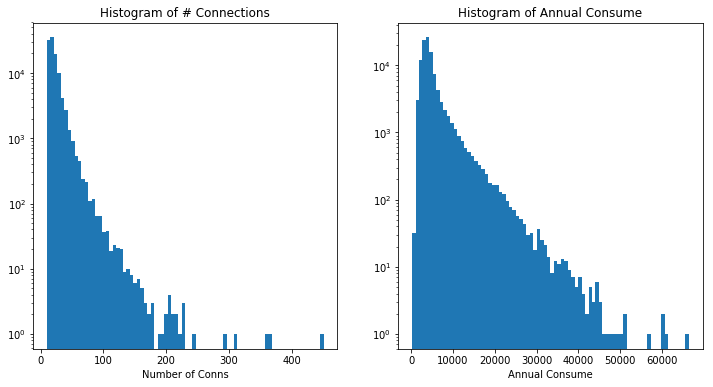

In [11]:
fig = plt.figure(figsize=(12, 6))
numc = fig.add_subplot(121)
cons = fig.add_subplot(122)

numc.hist(df.num_connections, bins=80)
numc.set_xlabel('Number of Conns')
numc.set_title("Histogram of # Connections")
numc.set_yscale('log')

cons.hist(df.annual_consume, bins=80)
cons.set_xlabel('Annual Consume')
cons.set_title("Histogram of Annual Consume")
cons.set_yscale('log')

plt.show()

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [13]:
m = ols('num_connections ~ annual_consume',df).fit()
print (m.summary())

                            OLS Regression Results                            
Dep. Variable:        num_connections   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.293
Date:                Sun, 24 Mar 2019   Prob (F-statistic):             0.0383
Time:                        12:31:02   Log-Likelihood:            -4.1569e+05
No. Observations:              107512   AIC:                         8.314e+05
Df Residuals:                  107510   BIC:                         8.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         21.3970      0.060    354.

In [14]:
#https://regex101.com/r/Vhrnul/2
pattern_1='20+[0-9]{2}'

In [15]:
years=re.findall(pattern_1,str(liste_fname))

In [16]:
dyears=set(years); dyears

{'2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019'}

In [17]:
def get_dataperyear(datalist,yearlist,pattern):
    match=[]
    for j in range(len(yearlist)):
        match.append([])
        for i in range(len(datalist)):
            patternfull=pattern+list(yearlist)[j]
            dummy = re.findall(patternfull,datalist[i])
            if dummy !=[]:
                match[j].append(dummy[0])
    
    return match

def flatten(liste):
    return [item for sublist in liste for item in sublist]

In [18]:
patternpart='.*elec.*'
sorted_energy=get_dataperyear(liste_fname,list(dyears),patternpart);sorted_energy

[['enexis_electricity_01012011',
  'liander_electricity_01012011',
  'stedin_electricity_2011'],
 ['enexis_electricity_01012013',
  'liander_electricity_01012013',
  'stedin_electricity_2013'],
 ['liander_electricity_01012009', 'stedin_electricity_2009'],
 ['enexis_electricity_01012014',
  'liander_electricity_01012014',
  'stedin_electricity_2014'],
 ['enexis_electricity_01012018',
  'liander_electricity_01012018',
  'stedin_electricity_2018'],
 ['enexis_electricity_01012016',
  'liander_electricity_01012016',
  'stedin_electricity_2016'],
 ['enexis_electricity_01012019',
  'liander_electricity_01012019',
  'stedin_electricity_2019'],
 ['enexis_electricity_01012012',
  'liander_electricity_01012012',
  'stedin_electricity_2012'],
 ['enexis_electricity_01012015',
  'liander_electricity_01012015',
  'stedin_electricity_2015'],
 ['liander_electricity_01012017',
  'enexis_electricity_01012017',
  'stedin_electricity_2017'],
 ['enexis_electricity_01012010',
  'liander_electricity_01012010'

In [19]:
len(sorted_energy)

11

In [20]:
def dfyear_wrapper(dflist,year):
    liste=[]
    df=[]
    for i in range(len(dflist)):
        df=pd.read_sql_query("select * from "+dflist[i],conn)
        df['year']=pd.Series(year,index=df.index)
        liste.append(df)
    return liste

In [21]:
aaa=dfyear_wrapper(sorted_energy[0],list(dyears)[0]);aaa[0].head(5)

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,delivery_perc,num_connections,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc,year
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,100,16,100,50,1X25,4961,34,0.0,2011
1,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,100,11,100,64,1X25,4517,13,0.0,2011
2,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,100,30,100,43,3X25,3675,31,0.0,2011
3,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,100,21,100,52,1X25,5249,48,0.0,2011
4,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,100,12,100,33,1X25,3226,33,0.0,2011


In [22]:
list(dyears)[0]

'2011'

In [23]:
sorted_energy[0]

['enexis_electricity_01012011',
 'liander_electricity_01012011',
 'stedin_electricity_2011']

In [24]:
db_name2='Dutch-ElectricityYear_DB.db'
conn2=lite.connect(db_name2)

Write_New=False

def merge_to_df(dflist_of_year,year):
    df_all=pd.DataFrame()
    isinstance(df_all, pd.DataFrame)
    for i in range(len(dflist_of_year)):
        df=pd.read_sql_query("select * from "+dflist_of_year[i],conn)
        df['year']=pd.Series(year,index=df.index)
        newdf=df_all.append(df,ignore_index=True,sort=True)
        df_all=newdf
    
    return newdf

if Write_New:
    for i in range(len(sorted_energy)):
        cur2 = conn2.cursor()
        cur2.execute('DROP TABLE IF EXISTS '+'Y'+str(sorted(dyears)[i]))
        print("Writing to db-file "+db_name2+": "+'Y'+str(sorted(dyears)[i]))
        df=merge_to_df(sorted_energy[i],sorted(dyears)[i])
        df.to_sql('Y'+sorted(dyears)[i], conn2, if_exists='replace', index=False) # - writes the pd.df to SQLIte DB
        pd.read_sql('select * from '+'Y'+str(sorted(dyears)[i]), conn2)
        conn2.commit()
    
    conn2.close()
    
#df.to_sql(liste_fname[i], conn, if_exists='replace', index=False)
#pd.merge(df1, df2, on='Customer_id', how='left')

Writing to db-file Dutch-ElectricityYear_DB.db: Y2009
Writing to db-file Dutch-ElectricityYear_DB.db: Y2010
Writing to db-file Dutch-ElectricityYear_DB.db: Y2011
Writing to db-file Dutch-ElectricityYear_DB.db: Y2012
Writing to db-file Dutch-ElectricityYear_DB.db: Y2013
Writing to db-file Dutch-ElectricityYear_DB.db: Y2014
Writing to db-file Dutch-ElectricityYear_DB.db: Y2015
Writing to db-file Dutch-ElectricityYear_DB.db: Y2016
Writing to db-file Dutch-ElectricityYear_DB.db: Y2017
Writing to db-file Dutch-ElectricityYear_DB.db: Y2018
Writing to db-file Dutch-ElectricityYear_DB.db: Y2019


In [25]:
bbb=merge_to_df(sorted_energy[0],list(dyears)[0]);bbb.head(5)

,annual_consume,annual_consume_lowtarif_perc,city,delivery_perc,net_manager,num_connections,perc_of_active_connections,purchase_area,smartmeter_perc,street,type_conn_perc,type_of_connection,year,zipcode_from,zipcode_to
0,4961,34.0,WERKENDAM,100.0,Enexis B.V.,16,100.0,ENEXIS,0.0,Sasdijk,50,1X25,2011,4251AB,4251AB
1,4517,13.0,WERKENDAM,100.0,Enexis B.V.,11,100.0,ENEXIS,0.0,Sasdijk,64,1X25,2011,4251AC,4251AC
2,3675,31.0,WERKENDAM,100.0,Enexis B.V.,30,100.0,ENEXIS,0.0,Sasdijk,43,3X25,2011,4251AD,4251AD
3,5249,48.0,WERKENDAM,100.0,Enexis B.V.,21,100.0,ENEXIS,0.0,Nieuweweg,52,1X25,2011,4251AE,4251AG
4,3226,33.0,WERKENDAM,100.0,Enexis B.V.,12,100.0,ENEXIS,0.0,Koppenhof,33,1X25,2011,4251AH,4251AH


In [26]:
len(aaa[0])

108299

In [27]:
len(bbb)

325219

In [28]:
sorted(dyears)

['2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']